In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

import pickle
import time

# Import Data

In [4]:
# df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
# df.head()

df = pickle.load(open('processed_df\preprocessed_nlp_100p.pkl','rb'))
df.head()

,Title,Userscore,Comment,lang
211190,Star Wars: Battlefront II,2.0,there nothing quite gun entire platoon clone d...,en
39249,The Witcher 3: Wild Hunt,10.0,game absolutely gorgeous run steady gtx hairwo...,en
204931,This War of Mine,10.0,really good game didnt expect first survival g...,en
75752,Golden Sun,10.0,people eagerly anticipate initial release game...,en
199503,Assassin's Creed IV: Black Flag,8.0,best assassin creed far open world fresh missi...,en


In [149]:
df.shape

(249031, 4)

In [5]:
print(f'shape before: {df.shape}')
df = df[df['Comment'] != '']
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print(f'shape after: {df.shape}')


shape before: (249031, 4)
shape after: (235301, 4)


# Train test split

In [6]:
X = df['Comment']
y = df['Userscore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# TFIDF text

In [8]:
# do TFIDF for X_train and X_test

def TFvec(n, X_train, X_test):
    start = time.time()

    bow_vec = TfidfVectorizer(max_features=n)
    X_tr_proc = bow_vec.fit_transform(X_train)
    X_te_proc = bow_vec.transform(X_test)

    end = time.time()
    print(f'{end-start} secs slipped..')    

    feat_names = bow_vec.get_feature_names_out()

    bow_mat_tr = pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)
    bow_mat_te = pd.DataFrame(X_te_proc.toarray(), columns = feat_names)

    return bow_mat_tr, bow_mat_te

In [82]:
bow_1000_tr, bow_1000_te = TFvec(1000,X_train, X_test)

8.312945365905762 secs slipped..


In [50]:
bow_2000_tr, bow_2000_te = TFvec(2000,X_train, X_test)

8.376627206802368 secs slipped..


In [152]:
start = time.time()

bow_vec = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_tr_proc = bow_vec.fit_transform(X_train)
X_te_proc = bow_vec.transform(X_test)

end = time.time()
print(f'{end-start} secs slipped..')

7.789936065673828 secs slipped..


In [153]:
feat_names = bow_vec.get_feature_names_out()

In [154]:
bow_mat_tr = pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)
bow_mat_te = pd.DataFrame(X_te_proc.toarray(), columns = feat_names)

In [155]:
bow_mat_tr.shape

(164710, 169)

# MODEL

- BASELINE, 165 VOL

In [43]:
bow_100_tr, bow_100_te = TFvec(100,X_train, X_test)

11.083112716674805 secs slipped..


In [56]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 1e-6, verbose = 1, patience=5)

model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=(100,)))
model_1.add(Dense(30, activation='relu'))
model_1.add(Dense(1, activation='linear'))

opt = Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model_1.compile(loss = "mean_squared_error", optimizer=opt, metrics=['mean_absolute_error'])

In [57]:
start = time.time()

results_1 = model_1.fit(bow_100_tr, y_train, validation_split = 0.2, epochs=50, batch_size=256, callbacks=[callback])

end = time.time()
print(f'{end-start} secs slipped...')

Epoch 1/50
515/515 [==============================] - 1s 2ms/step - loss: 21.9749 - mean_absolute_error: 3.7392 - val_loss: 6.3606 - val_mean_absolute_error: 1.9907
Epoch 2/50
515/515 [==============================] - 1s 1ms/step - loss: 5.5810 - mean_absolute_error: 1.8330 - val_loss: 5.0616 - val_mean_absolute_error: 1.7308
Epoch 3/50
515/515 [==============================] - 1s 1ms/step - loss: 4.9144 - mean_absolute_error: 1.6915 - val_loss: 4.7142 - val_mean_absolute_error: 1.6507
Epoch 4/50
515/515 [==============================] - 1s 1ms/step - loss: 4.7531 - mean_absolute_error: 1.6489 - val_loss: 4.6530 - val_mean_absolute_error: 1.6281
Epoch 5/50
515/515 [==============================] - 1s 2ms/step - loss: 4.7281 - mean_absolute_error: 1.6397 - val_loss: 4.6506 - val_mean_absolute_error: 1.6437
Epoch 6/50
515/515 [==============================] - 1s 2ms/step - loss: 4.7168 - mean_absolute_error: 1.6367 - val_loss: 4.6361 - val_mean_absolute_error: 1.6070
Epoch 7/50
515/

In [58]:
history_dict = results_1.history
history_dict.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

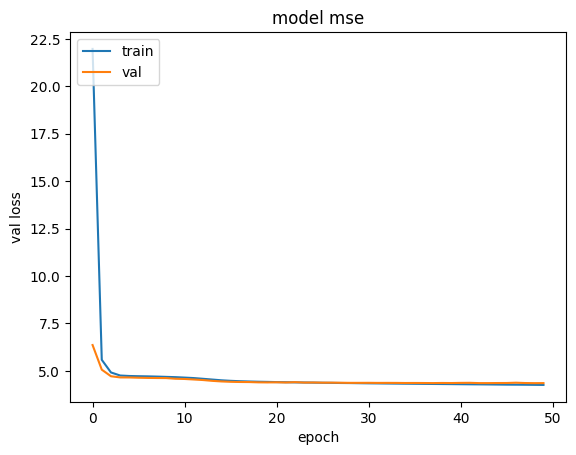

In [59]:
plt.plot(results_1.history['loss'])
plt.plot(results_1.history['val_loss'])
plt.title('model mse')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

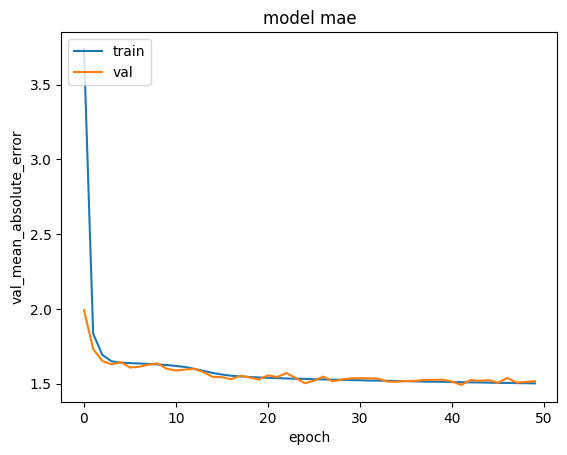

In [62]:
plt.plot(results_1.history['mean_absolute_error'])
plt.plot(results_1.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('val_mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
model_1.evaluate(bow_100_te, y_test)

2206/2206 [==============================] - 2s 682us/step - loss: 4.4784 - mean_absolute_error: 1.5349


[4.478437900543213, 1.5348979234695435]

In [63]:
y_pred = model_1.predict(bow_100_te)
print(f'test MSE {mean_squared_error(y_test, y_pred)}')
print(f'test MAE {mean_absolute_error(y_test, y_pred)}')
print(f'test r2 {r2_score(y_test, y_pred)}')

y_pred = model_1.predict(bow_100_tr)
print(f'train MSE {mean_squared_error(y_train, y_pred)}')
print(f'train MAE {mean_absolute_error(y_train, y_pred)}')
print(f'train r2 {r2_score(y_train, y_pred)}')


2206/2206 [==============================] - 1s 613us/step
test MSE 4.478441835324473
test MAE 1.5348990701828293
test r2 0.24799797349748676
5148/5148 [==============================] - 3s 608us/step
train MSE 4.259982962356841
train MAE 1.500533491850377
train r2 0.28335012153577654


run on full dataset, 164,710<br>
165 vocabulary

- BASELINE, 200 VOL

In [9]:
bow_200_tr, bow_200_te = TFvec(200,X_train, X_test)

10.535192489624023 secs slipped..


In [29]:
bow_300_tr, bow_300_te = TFvec(300,X_train, X_test)

10.726866722106934 secs slipped..


In [12]:
start = time.time()

bow_vec = TfidfVectorizer(max_features=400)
X_tr_proc = bow_vec.fit_transform(X_train)
X_te_proc = bow_vec.transform(X_test)

end = time.time()
print(f'{end-start} secs slipped..')

feat_names = bow_vec.get_feature_names_out()

bow_400_tr = pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)
bow_400_te = pd.DataFrame(X_te_proc.toarray(), columns = feat_names)

bow_400_tr.shape, bow_400_te.shape

11.001920700073242 secs slipped..


((164710, 400), (70591, 400))

In [69]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 1e-6, verbose = 1, patience=5)

model_3 = Sequential()
model_3.add(Dense(64, activation='relu', input_shape=(200,)))
model_3.add(Dense(30, activation='relu'))
model_3.add(Dense(1, activation='linear'))

opt = Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model_3.compile(loss = "mean_squared_error", optimizer=opt, metrics=['mean_absolute_error'])

In [70]:
start = time.time()

results_3 = model_3.fit(bow_200_tr, y_train, validation_split = 0.2, epochs=50, batch_size=512, callbacks=[callback])

end = time.time()
print(f'{end-start} secs slipped...')

Epoch 1/50
258/258 [==============================] - 1s 2ms/step - loss: 36.8605 - mean_absolute_error: 5.2765 - val_loss: 9.0871 - val_mean_absolute_error: 2.5015
Epoch 2/50
258/258 [==============================] - 1s 2ms/step - loss: 7.4632 - mean_absolute_error: 2.2104 - val_loss: 6.0462 - val_mean_absolute_error: 1.9320
Epoch 3/50
258/258 [==============================] - 0s 2ms/step - loss: 5.4622 - mean_absolute_error: 1.8183 - val_loss: 5.0598 - val_mean_absolute_error: 1.7474
Epoch 4/50
258/258 [==============================] - 0s 2ms/step - loss: 4.8643 - mean_absolute_error: 1.7004 - val_loss: 4.6584 - val_mean_absolute_error: 1.6560
Epoch 5/50
258/258 [==============================] - 0s 2ms/step - loss: 4.5866 - mean_absolute_error: 1.6373 - val_loss: 4.4580 - val_mean_absolute_error: 1.6108
Epoch 6/50
258/258 [==============================] - 0s 2ms/step - loss: 4.4624 - mean_absolute_error: 1.6039 - val_loss: 4.3760 - val_mean_absolute_error: 1.5742
Epoch 7/50
258/

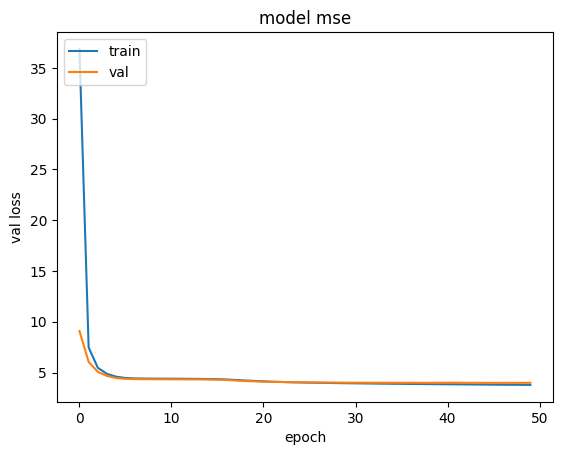

In [71]:
plt.plot(results_3.history['loss'])
plt.plot(results_3.history['val_loss'])
plt.title('model mse')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

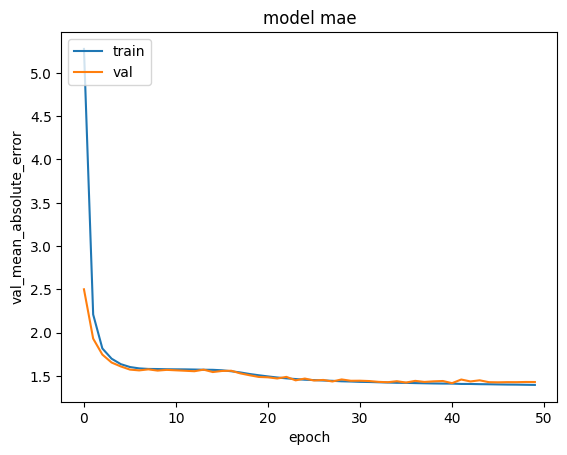

In [72]:
plt.plot(results_3.history['mean_absolute_error'])
plt.plot(results_3.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('val_mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [73]:
y_pred = model_3.predict(bow_200_te)
print(f'test MSE {mean_squared_error(y_test, y_pred)}')
print(f'test MAE {mean_absolute_error(y_test, y_pred)}')
print(f'test r2 {r2_score(y_test, y_pred)}')

y_pred = model_3.predict(bow_200_tr)
print(f'train MSE {mean_squared_error(y_train, y_pred)}')
print(f'train MAE {mean_absolute_error(y_train, y_pred)}')
print(f'train r2 {r2_score(y_train, y_pred)}')


2206/2206 [==============================] - 1s 629us/step
test MSE 4.0726863334929835
test MAE 1.4462170184112024
test r2 0.3161308131907631
5148/5148 [==============================] - 3s 625us/step
train MSE 3.799707396632754
train MAE 1.3977181451350034
train r2 0.36078151765894906


In [92]:
df100 = pickle.load(open('processed_df\preprocessed_nlp_100p.pkl','rb'))

df100.to_csv(r'processed_df\preprocessed_nlp_100p.csv', index = False)



# IMPUTE USERSCORE FOR STEAM REVIEWS

In [83]:
df_steam = pd.read_csv('processed_df\preprocessed_nlp_steam_full.csv')
df_steam.head()

,review_id,title,year,user_review,user_suggestion,lang,Comment_len
0,5674,Yu-Gi-Oh! Duel Links,2018.0,worth new player take time get new card pay an...,1,en,193
1,23155,AdventureQuest 3D,2016.0,early access reviewrereview wogloween update u...,1,en,282
2,19390,Creativerse,2015.0,early access reviewhonestly start well tried f...,1,en,4646
3,10559,Trove,2016.0,trion world awful really pay win go backwards ...,0,en,1181
4,18948,Fallout Shelter,2017.0,mean fun game bore hit play fun time go repeti...,1,en,233


In [84]:
df_steam = df_steam['user_review']

In [89]:
start = time.time()

bow_vec = TfidfVectorizer(max_features=200)
bow_vec.fit(X_train)
X_imp = bow_vec.transform(df_steam)

end = time.time()
print(f'{end-start} secs slipped..')


8.487502813339233 secs slipped..


In [90]:
X_imp.shape

(17080, 200)

In [94]:
y_pred = model_3.predict(X_imp)

InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,180] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

In [95]:
type(X_imp)

scipy.sparse._csr.csr_matrix

In [96]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [97]:
X_imp_tf = convert_sparse_matrix_to_sparse_tensor(X_imp)

In [98]:
y_pred = model_3.predict(tf.sparse.reorder(X_imp_tf))

534/534 [==============================] - 0s 734us/step


In [99]:
y_pred

array([[7.6519337],
       [7.5205393],
       [6.3565893],
       ...,
       [6.1686544],
       [8.217991 ],
       [8.446318 ]], dtype=float32)